# A toy statistical model of ice thickness

This notebook primarily introduces the `gis.gridded_attributes` and `gis.gridded_mb_attributes` tasks which are simply adding certain diagnostic variables to the glacier maps such as slope, aspect, distance from border, and other mass-balance related variables which might be useful to some people.

We also show how to use these data to build a very simple (and not very good) regression model of ice thickness. This second part ("Build a statistical model") is rather technical and not directly related to OGGM, so you might stop at this point unless your are into the topic yourself. You will need to install [scikit-learn](https://scikit-learn.org/stable/index.html) for the second part of this notebook.

## Set-up 

We are going to use the South Glacier example taken from the [ITMIX experiment](https://www.the-cryosphere.net/11/949/2017/). We'll also use the data provided with it.

In [1]:
## Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import salem

# OGGM
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, graphics

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = False
# Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] = utils.gettempdir('OGGM_Toy_Thickness_Model')
# We start at level 3, because we need all data for the attributes
gdirs = workflow.init_glacier_directories(['RGI60-01.16195'], from_prepro_level=3, prepro_border=10)

/home/mowglie/disk/Dropbox/HomeDocs/git/oggm-fork/oggm/cfg.py:377: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2021-02-03 13:19:28: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-03 13:19:28: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-03 13:19:28: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-03 13:19:29: oggm.cfg: Multi

These are the tasks adding the attributes to the gridded file:

In [3]:
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    tasks.gridded_mb_attributes,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs)

2021-02-03 13:19:39: oggm.workflow: Execute entity task gridded_attributes on 1 glaciers
2021-02-03 13:19:39: oggm.workflow: Execute entity task gridded_mb_attributes on 1 glaciers


In [4]:
# Pick our glacier
gdir = gdirs[0]

## The gridded attributes 

Let's open the gridded data file with xarray:

In [5]:
ds = xr.open_dataset(gdir.get_filepath('gridded_data'))
# List all variables
ds

<xarray.Dataset>
Dimensions:                   (x: 105, y: 121)
Coordinates:
  * x                         (x) float32 -2.407e+03 -2.364e+03 ... 2.065e+03
  * y                         (y) float32 6.746e+06 6.745e+06 ... 6.74e+06
Data variables:
    topo                      (y, x) float32 ...
    topo_smoothed             (y, x) float32 ...
    topo_valid_mask           (y, x) int8 ...
    glacier_mask              (y, x) int8 ...
    glacier_ext               (y, x) int8 ...
    glacier_ext_erosion       (y, x) int8 ...
    ice_divides               (y, x) int8 ...
    slope                     (y, x) float32 ...
    aspect                    (y, x) float32 ...
    slope_factor              (y, x) float32 ...
    dis_from_border           (y, x) float32 ...
    catchment_area            (y, x) float32 ...
    catchment_area_on_catch   (y, x) float32 ...
    lin_mb_above_z            (y, x) float32 ...
    lin_mb_above_z_on_catch   (y, x) float32 ...
    oggm_mb_above_z           (y, x) float32 ...
    oggm_mb_above_z_on_catch  (y, x) float32 ...
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=-139.131 +k=0.9996 +x_0=0 +y_...
    max_h_dem:      3158.8242
    min_h_dem:      1804.8026
    max_h_glacier:  3158.8242
    min_h_glacier:  1971.5164

The file contains several variables with their description. For example:

In [6]:
ds.oggm_mb_above_z

<xarray.DataArray 'oggm_mb_above_z' (y: 121, x: 105)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float32 -2.407e+03 -2.364e+03 ... 2.022e+03 2.065e+03
  * y        (y) float32 6.746e+06 6.745e+06 6.745e+06 ... 6.74e+06 6.74e+06
Attributes:
    units:        kg/year
    long_name:    MB above point from OGGM MB model, without catchments
    description:  Mass-balance cumulated above the altitude of thepoint, henc...

Let's plot a few of them (we show how to plot them with xarray and with oggm:

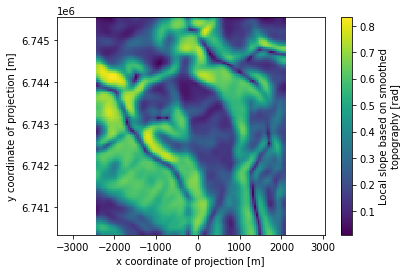

In [7]:
ds.slope.plot();
plt.axis('equal');

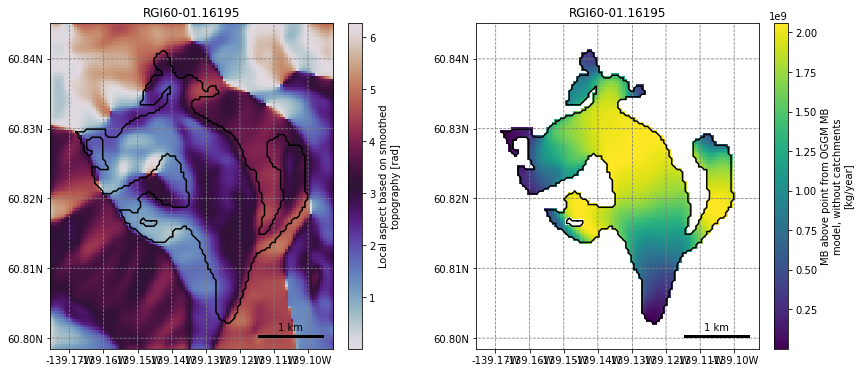

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
graphics.plot_raster(gdir, var_name='aspect', cmap='twilight', ax=ax1)
graphics.plot_raster(gdir, var_name='oggm_mb_above_z', ax=ax2)

## Retrieve these attributes at point locations 

For this glacier, we have ice thickness observations (all downloaded from the supplementary material of the [ITMIX paper](https://www.the-cryosphere.net/11/949/2017/)). Let's make a table out of it:

In [9]:
df = salem.read_shapefile(utils.get_demo_file('IceThick_SouthGlacier.shp'))
coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
df = df[['lon', 'lat', 'thick']]

Convert the longitudes and latitudes to the glacier map projection:

In [10]:
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

And plot these data:

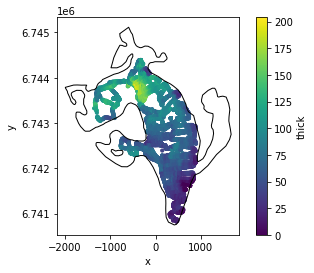

In [11]:
geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
df.plot.scatter(x='x', y='y', c='thick', cmap='viridis', s=10, ax=ax);
geom.plot(ax=ax, facecolor='none', edgecolor='k');

### Method 1: interpolation 

The measurement points of this dataset are very frequent and close to each other. There are plenty of them:

In [12]:
len(df)

9619

Here, we will keep them all and interpolate the variables of interest at a the point's location. We use [xarray](http://xarray.pydata.org/en/stable/interpolation.html#advanced-interpolation) for this:

In [13]:
vns = ['topo',
       'slope',
       'slope_factor',
       'aspect',
       'dis_from_border',
       'catchment_area',
       'lin_mb_above_z',
       'lin_mb_above_z_on_catch',
       'oggm_mb_above_z',
       'oggm_mb_above_z_on_catch',
       ]

In [14]:
# Interpolate (bilinear)
for vn in vns:
    df[vn] = ds[vn].interp(x=('z', df.x), y=('z', df.y))

Let's see how these variables can explain the measured ice thickness:

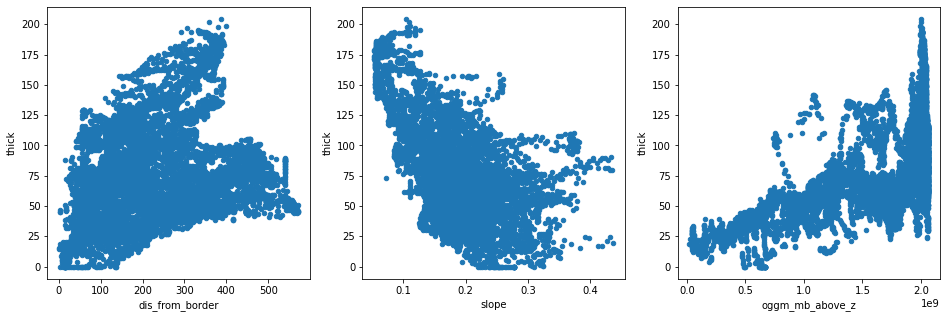

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df.plot.scatter(x='dis_from_border', y='thick', ax=ax1);
df.plot.scatter(x='slope', y='thick', ax=ax2);
df.plot.scatter(x='oggm_mb_above_z', y='thick', ax=ax3);

There is a negative correlation with slope (as expected), with the mass-flux, and a slight correlation with the distance from the glacier boundaries.

### Method 2: aggregated per grid point

There are so many points that much of the information obtained by OGGM is interpolated. A way to deal with this is to aggregate all the measurement points per grid point and average them. Let's do this: 

In [16]:
df_agg = df[['lon', 'lat', 'thick']].copy()
ii, jj = gdir.grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# We trick by creating an index of similar i's and j's
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [17]:
len(df_agg)

1087

In [18]:
# Select
for vn in vns:
    df_agg[vn] = ds[vn].isel(x=('z', df_agg.i), y=('z', df_agg.j))

We now have 9 times less points, but the main features of the data remain unchanged:

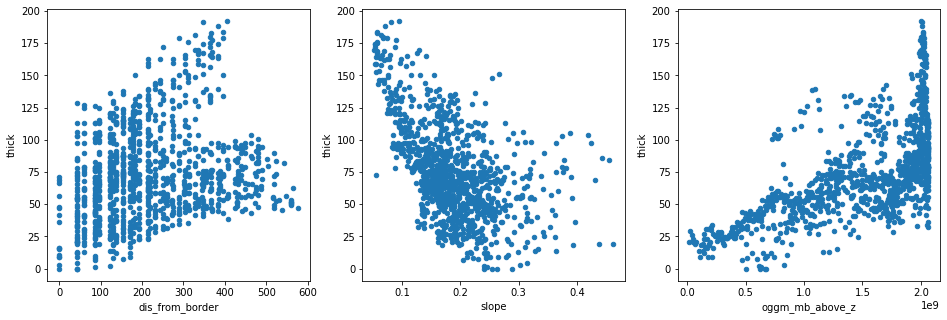

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df_agg.plot.scatter(x='dis_from_border', y='thick', ax=ax1);
df_agg.plot.scatter(x='slope', y='thick', ax=ax2);
df_agg.plot.scatter(x='oggm_mb_above_z', y='thick', ax=ax3);

## Build a statistical model 

Let's use scikit-learn to build a very simple linear model of ice-thickness. First, we have to acknowledge that there is a correlation between many of the explanatory variables we will use:

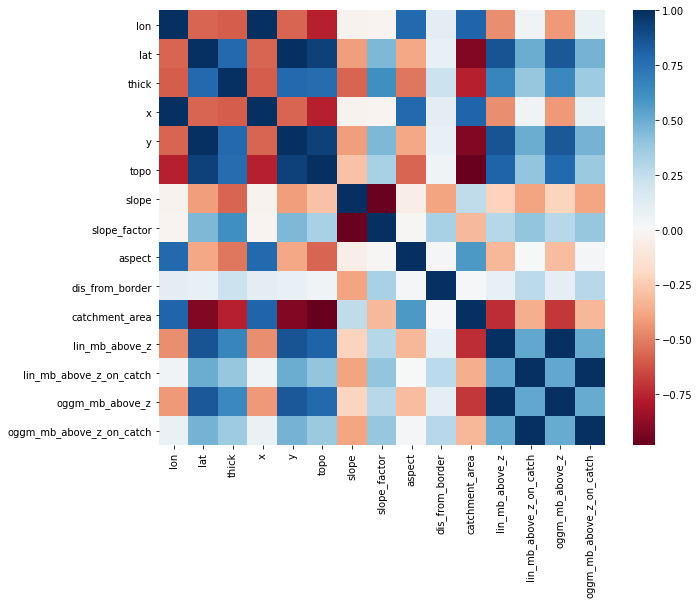

In [20]:
import seaborn as sns
plt.figure(figsize=(10, 8));
sns.heatmap(df.corr(), cmap='RdBu');

This is a problem for linear regression models, which cannot deal well with correlated explanatory variables. We have to do a so-called "feature selection", i.e. keep only the variables which are independently important to explain the outcome.

For the sake of simplicity, let's use the [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)) method to help us out:

In [23]:
import warnings
warnings.filterwarnings("ignore")  # sklearn sends a lot of warnings
# Scikit learn
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

In [24]:
# Prepare our data
df = df.dropna()
# Variable to model
target = df['thick']
# Predictors - remove x and y (redundant with lon lat)
# Normalize it in order to be able to compare the factors
data = df.drop(['thick', 'x', 'y'], axis=1).copy()
data_mean = data.mean()
data_std = data.std()
data = (data - data_mean) / data_std

In [25]:
# Use cross-validation to select the regularization parameter
lasso_cv = LassoCV(cv=5, random_state=0)
lasso_cv.fit(data.values, target.values)

LassoCV(cv=5, random_state=0)

We now have a statistical model trained on the full dataset. Let's see how it compares to the calibration data:

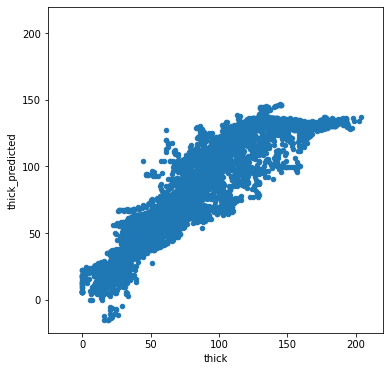

In [26]:
odf = df.copy()
odf['thick_predicted'] = lasso_cv.predict(data.values)
f, ax = plt.subplots(figsize=(6, 6));
odf.plot.scatter(x='thick', y='thick_predicted', ax=ax);
plt.xlim([-25, 220]);
plt.ylim([-25, 220]);

Not so well. It is doing OK for low thicknesses, but high thickness are strongly underestimated. Which explanatory variables did the model choose as being the most important?

In [27]:
predictors = pd.Series(lasso_cv.coef_, index=data.columns)
predictors

lon                         -6.656674
lat                         12.169156
topo                         0.000000
slope                       -0.000000
slope_factor                14.816200
aspect                      -7.347009
dis_from_border              1.572589
catchment_area              -0.000000
lin_mb_above_z               2.911900
lin_mb_above_z_on_catch      0.000000
oggm_mb_above_z              0.000000
oggm_mb_above_z_on_catch     0.000000
dtype: float64

This is interesting. Lons and lats have a predictive power over thickness? Unfortunately, this is more a coincidence than a reality. If we look at the correlation of the error with the variables of importance, one sees that there is a large correlation between the error and the spatial variables:

In [28]:
odf['error'] = np.abs(odf['thick_predicted'] - odf['thick'])
odf.corr()['error'].loc[predictors.loc[predictors != 0].index]

lon               -0.319254
lat                0.377451
slope_factor       0.267810
aspect            -0.174002
dis_from_border    0.030893
lin_mb_above_z     0.276429
Name: error, dtype: float64

Furthermore, the model is not very robust. Let's use cross-validation to check our model parameters:

In [30]:
k_fold = KFold(4, random_state=0, shuffle=True)
for k, (train, test) in enumerate(k_fold.split(data.values, target.values)):
    lasso_cv.fit(data.values[train], target.values[train])
    print("[fold {0}] alpha: {1:.5f}, score (r^2): {2:.5f}".
          format(k, lasso_cv.alpha_, lasso_cv.score(data.values[test], target.values[test])))

[fold 0] alpha: 1.24808, score (r^2): 0.81012
[fold 1] alpha: 1.36866, score (r^2): 0.81543
[fold 2] alpha: 1.26360, score (r^2): 0.81808
[fold 3] alpha: 1.35423, score (r^2): 0.81607


The fact that the hyper-parameter alpha and the score change that much between iterations is a sign that the model isn't very robust.

### Our model is bad, but... let's apply it 

In order to apply the model to our entre glacier, we have to get the explanatory variables from the gridded dataset again:

In [31]:
# Add variables we are missing
lon, lat = gdir.grid.ll_coordinates
ds['lon'] = (('y', 'x'), lon)
ds['lat'] = (('y', 'x'), lat)

# Generate our dataset
pred_data = pd.DataFrame()
for vn in data.columns:
    pred_data[vn] = ds[vn].data[ds.glacier_mask == 1]

# Normalize using the same normalization constants
pred_data = (pred_data - data_mean) / data_std

# Apply the model
pred_data['thick'] = lasso_cv.predict(pred_data.values)

# For the sake of physics, clip negative thickness values...
pred_data['thick'] = np.clip(pred_data['thick'], 0, None)

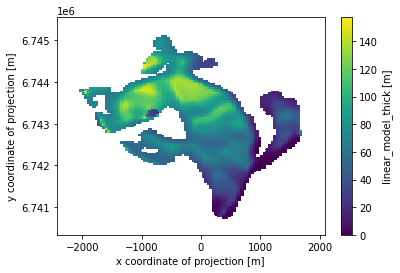

In [32]:
# Back to 2d and in xarray
var = ds[vn].data * np.NaN
var[ds.glacier_mask == 1] = pred_data['thick']
ds['linear_model_thick'] = (('y', 'x'), var)
ds['linear_model_thick'].attrs['description'] = 'Predicted thickness'
ds['linear_model_thick'].attrs['units'] = 'm'
ds['linear_model_thick'].plot();

## Take home points

- we have shown how to compute gridded attributes from OGGM glaciers such as slope, aspect, or catchments
- we used two methods to extract these data at point locations: with interpolation or with aggregated averages on each grid point
- as an application example, we trained a linear regression model to predict the ice thickness of this glacier at unseen locations

The model we developed was quite bad and we used quite lousy statistics. If I had more time to make it better, I would:
- make a pre-selection of meaningful predictors to avoid discontinuities
- use a non-linear model
- use cross-validation to better asses the true skill of the model
- ...

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)

### Bonus: how does the statistical model compare to OGGM "out-of the box"? 

In [33]:
# Close the dataset cause we are going to write in it
ds = ds.load()
ds.close()
ds.to_netcdf(gdir.get_filepath('gridded_data'))
# Distribute thickness using default values only
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

2021-02-03 13:21:19: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 1 glaciers


In [34]:
# Add the linear model data for comparison
ds = xr.open_dataset(gdir.get_filepath('gridded_data'))
df_agg['oggm_thick'] = ds.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))
df_agg['linear_model_thick'] = ds.linear_model_thick.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))

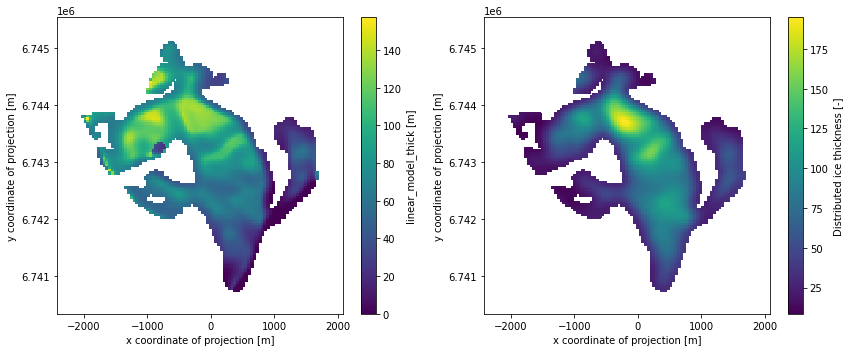

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5));
ds['linear_model_thick'].plot(ax=ax1);
ds['distributed_thickness'].plot(ax=ax2);
plt.tight_layout();

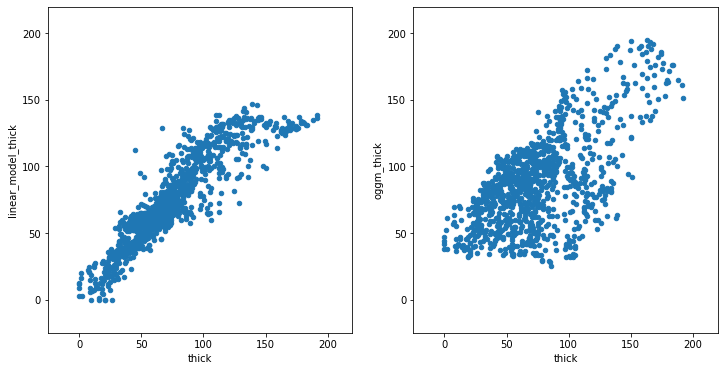

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6));
df_agg.plot.scatter(x='thick', y='linear_model_thick', ax=ax1);
ax1.set_xlim([-25, 220]);
ax1.set_ylim([-25, 220]);
df_agg.plot.scatter(x='thick', y='oggm_thick', ax=ax2);
ax2.set_xlim([-25, 220]);
ax2.set_ylim([-25, 220]);